# Klasifikácia informácií s TensorFlow

### Rozpoznávanie ručne písaných čísel s pomocou neuronových sietí

<div align="right"><h3>Miroslav Semerád</h3></div>
<div align="right"><h4>Miroslav_Semerad@swissre.com</h4></div>
<div align="right"><h4>@mldeveloper</h4></div>

## O čom je dnešný workshop:

#### - Úvod do problematiky detekcie ručne písaných čísel
#### - MNIST - dataset číslic
#### - Detekcia čísla z obrázka pomocou softmax regresie
#### - Zvýšenie presnosti pomocou konvolučnej neurónove siete
#### - Integrácia modelu do web aplikácie

## Úvod do problematiky detekcie ručne písaných čísel

- Vezmime si do úvahy hypotetickú situáciu.
- Máme veľké množstvo naskenovaných dokumentov s ručne písanými číslami (napr. dátum, cena, množstvo).
- OCR technológie fungujú skvele pri tlačených znakoch no s ručne písaným textom majú častokrát problémy.
- My však potrebujeme práve tieto hodnoty, aby sme vedeli zmluvu správne zaradiť.
- Môžeme na to vybudovať jednoduchý klasifikátor, ktorý vyčíta jednotlivé čísla zo skenu a vráti nám ich v textovej podobe.

![detection](images/detection.png?arg)



### MNIST - dataset číslic

- Je voľne dostupný na webe.
- Obsahuje 60000 obrázkov ručne písaných číslic 0 až 9.
- Obrázky sú čiernobiele (1 farebný kanál) s rozlíšením 28 x 28 pixelov.
- Každý obrázok je sploštený na pole 784 reálnych čísel - hodnota každého pixelu.    
- Dataset je rozdelený na trénovaciu (55000) a testovaciu (5000) sadu.
- Dataset obsahuje menovku (label) pre každé jedno číslo. 

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Ukážka z datasetu

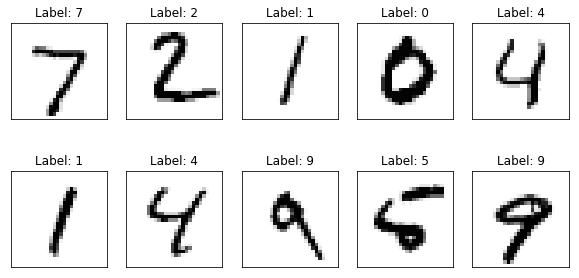

In [4]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
%matplotlib inline

fig = plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    example = mnist.test.images[i]
    example_label = "Label: %s"%[a for a,b in enumerate(mnist.test.labels[i]) if b == 1][0]
    plt.title(example_label)
    plt.imshow(example.reshape([28,28]), cmap = cm.Greys)
    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)
plt.show()

#code hiding
from IPython.display import HTML
HTML('''<script>
code_show=false; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 

$( document ).ready(code_toggle);
</script>

<a href="javascript:code_toggle()">Zobraziť kód</a>.''')

### Ako využijeme tento dataset?

Dataset nám poslúži na natrénovanie modelu, keďže obsahuje nielen obrázky ale aj menovky.

Keď bude model natrénovaný, použijeme ho na klasifikáciu nových dát.

![training](images/training.png?arg)

## Jednoduchá klasifikácia pomocou softmax regresie

Na úvod si ukážeme ako sa dá vytvoriť jednoduchý model na báze softmax regresie.

V prvom kroku si ukážeme ako naimportovat TensorFlow a vytvoriť Session.

### TensorFlow InteractiveSession

- TensorFlow je knižnica na numerické výpočty od Google.
- Je postavená na princípe data flow grafu.
- Všetky výpočtové operácie sa ukladajú do grafu - operácie nie sú vykonané okamžite.
- Na spustenie výpočtu je potrebná Session.
- InteractiveSession je abstrakcia nad Session - umožňuje jedonuchšiu prácu so session.

In [5]:
import tensorflow as tf
sess = tf.InteractiveSession()
print("Version: %s"%tf.__version__)

Version: 1.0.1


### Placeholders - vstupné premenné

Na to aby sme mohli do nášho modelu posielať externé dáta potrebujeme definovať vstupné premenné.

- **x**  vstupné obrázky vo formáte 784 miestneho poľa
- **y_** menovky vstupných obrázkov 0 - 10 (správne odpovede)   

In [6]:
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

### Premenné modelu

Sú to lokálne premenné, ktoré nebudeme manuálne meniť.

Model mení ich hodnoty pri trénovaní.

- **W** - weights - je to matica váh, jej rozmery sú 784 x 10 (pixel vs. číslica)
- **b** - bias - predpoklad, určité čísla sú v datasete viac zastúpené ako ostatné, táto hodnota nám umožnuje posúvať krivku pre každú číslicu na základe jej zastúpenia a tým zabezpečiť adekvátne zastúpenie všetkých čísel.

In [7]:
W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))

### Inicializácia premenných

Pred použitím premenných v modeli je potrebná ich inicializácia na nulové hodnoty.

In [8]:
sess.run(tf.global_variables_initializer())

### Lineárny model

Použijeme nasledovnú lineárnu funkciu:

### y = x*W + b

Výnasobíme pole pixelov obrázka (x) maticou váh (W) a pripočítame predpoklad (b).  

In [9]:
y = tf.add(tf.matmul(x,W), b)

### Softmax nákladová funkcia

Nákladová funkcia (cost function) slúži na výpočet toho aký veľký je rozdiel medzi menovkou predikovanou modelom a skutočnou menovkou.

Trénovanie je hlavne o minimalizácií tejto funkcie resp. čo najvačšie priblíženie skutočnej hodnoty s predikovanou.

Softmax je normalizovaná exponenciálna funcia.

Túto funkciu aplikujeme na vstupný tensor a vypočítame takzvanú krížovú entropiu pre každú kategóriu (0-9).

Na tieto matematické operácie existujú zabudované funkcie priamo v knižnici TensorFlow.

- **tf.nn.softmax_cross_entropy_with_logits** - aplikuje softmax na predikcie a zosumarizuje podľa jednotlivých kategórií
- **tf.reduce_mean** - vypočíta aritmetický priemer zo všetkých kategórií

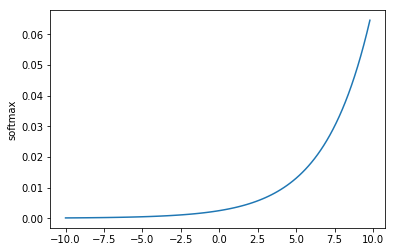

In [11]:
import numpy as np
npa = np.array
def softmax(w, t = 3.0):
    e = np.exp(npa(w) / t)
    dist = e / np.sum(e)
    return dist

arr = np.arange(-10., 10., 0.2)
sig = softmax(arr)

plt.plot(arr, sig)
plt.ylabel('softmax')
plt.show()

#code hiding
from IPython.display import HTML
HTML('''<script>
code_show=false; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 

$( document ).ready(code_toggle);
</script>

<a href="javascript:code_toggle()">Zobraziť kód</a>.''')

In [12]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y, labels=y_))

### Trénovanie modelu

Optimizer - je matematický algoritmus, ktorý vykonáva minimalizáciu nákladovej funkcie.

Gradient Descent - je optimalizačný algoritmus, ktorý iteratívne upravuje parametre (W, b) aby dosiahol minimalizáciu funkcie.

*V každej iterácii vyráta ideálny sklon a upraví hodnoty na základe veľkosti kroku.*

- použijeme **GradientDescentOptimizer** s veľkosťou kroku 0.5 
- trénujeme dávkovo po 100 obrázkoch

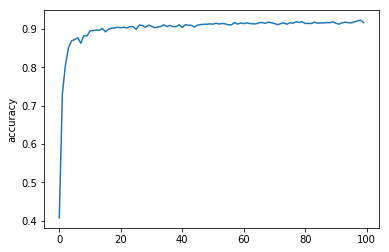

In [13]:
# define functions to measure accuracy
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# we will store accuracies in a list
acc_steps = []

# define our train step using the Gradient Descent Optimizer
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

# training iterations
for i in range(1000):
    batch = mnist.train.next_batch(100)
    train_step.run(feed_dict={x: batch[0], y_: batch[1]})
    if i%10==0:        
        acc_steps.append(accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels}))
    
# visualize accuracy
plt.plot(acc_steps)
plt.ylabel('accuracy')
plt.show()

In [14]:
print("Presnosť %.f"%((acc_steps[-1])*100))

Presnosť 92


### Vizualizácia váh

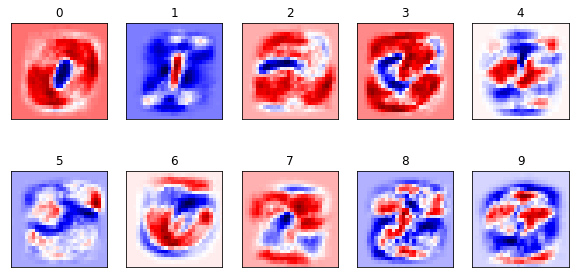

In [16]:
fig = plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    weight = sess.run(W)[:,i]
    plt.title(i)
    plt.imshow(weight.reshape([28,28]), cmap=plt.get_cmap('seismic'))
    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)
plt.show()

#code hiding
from IPython.display import HTML
HTML('''<script>
code_show=false; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 

$( document ).ready(code_toggle);
</script>

<a href="javascript:code_toggle()">Zobraziť kód</a>.''')

### Ako zvýšiť presnosť nášho modelu?

- Táto presnosť je nedostatočná na praktické nasadenie nášho modelu.
- Na zvýšenie presnosti potrebujeme použiť komplexnejší model, ktorý sa lepšie naučí komplexnejšie charakteristiky písaných čísiel.

## Konvolučná neurónová sieť

Neurónová sieť je výpočtový model, zostavený na základe abstrakcie vlastností biologických nervových systémov.

Základnou časťou neurónovej siete je model neurónu s N vstupmi a M výstupmi.

Konvolučná neurónvá sieť je špeciálny druh neurónovej siete, ktorá je inšpirovaná funkciou zrakového centra v mozgu.

Konvolúcia spočíva v rozdelení neurónov regióny, ktoré reagujú na určité vnemy.

KNS sa používajú hlavne na vizuálnu klasifikáciu objektov a textu z obrázkov a videí.




### Vrstvy konvolučnej neurónovej siete

#### INPUT -> CONV -> RELU -> POOL -> CONV -> RELU -> POOL -> FC -> SOFTMAX -> OUTPUT

- CONV - konvolučná vrstva
- RELU - aktivačná vrstva
- POOL - max pooling vrstva - subsampling
- FC - plne prepojená vrstva
- SOFTMAX - softmax regresia

### Pomocné funkcie

Na zjednodušenie implementácie neurónovej sieťe si zadefinujeme zopár pomocných funkcií. 

In [17]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

x_image = tf.reshape(x, [-1,28,28,1])

### Prvá CONV vrstva

- detekuje 32 vlastností pre každy 5x5 región.
- konvolučné vrstvy na rozdiel od bežných neuronových sietí nie sú husto prepojené
- spojené sú len súvisiace regióny

Váhy majú tentokrát dimenzie [5, 5, 1, 32], ktoré predstavujú:
- šírka výrezu
- výška výrezu
- počet vstupov - v našom prípade farebných kanálov
- počet výstupných kanálov = počet neurónov pre každý región

![conv](images/conv.png?arg)

In [18]:
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

### Použijeme ReLU aktivačnú funkciu

Rectified Linear unit - všetky negatívne hodnoty premeníme na nuly.

### f(x) = max(0,x)

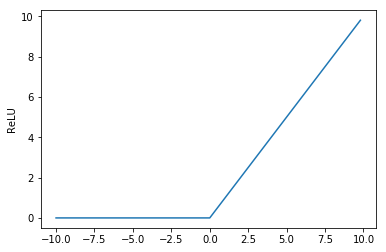

In [20]:
import numpy as np
npa = np.array
def relu(a):
    return a.clip(min=0)

arr = np.arange(-10., 10., 0.2)
sig = relu(arr)

plt.plot(arr, sig)
plt.ylabel('ReLU')
plt.show()

#code hiding
from IPython.display import HTML
HTML('''<script>
code_show=false; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 

$( document ).ready(code_toggle);
</script>

<a href="javascript:code_toggle()">Zobraziť kód</a>.''')

### Max Pooling (subsampling)

V podstate jednoduchý nelineárny down-sampling.

V princípe rozelíme obrázok na časti o veľkosti 2x2 pixelov.

Z každej časti ponecháme najvyššiu hodnotu.

#### Zmení rozlíšenie z 28x28 na 14x14

![pool](images/max_pool.png?arg)

In [21]:
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

### Druhá CONV vrstva

- Pobobná prvej vrstve
- 5x5 výrez
- 32 vstupov
- 64 výstupov

#### Max Pooling opäť zníži rozlíšenie na 7x7

In [22]:
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

### Plne prepojená vrstva

Aby bolo možné detekovať všetky vlastnosti kdekoľvek na obrázku pridáme plne prepojenú vrstvu.

Táto vrstva nám umožní prepojiť všetky regióny, ktoré vznikli pri konvolúcií.

V podstate každý neurón tejto vrstvy je prepojený s každým výstupom predošlej vrstvy.

Počet výstupov 1024.

![fc](images/FCLayer.png?arg)

### Výstup nakoniec transformujeme na 1D pole s 196 hodnotami (7x7x64)

In [23]:
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

### Dropout

Dropout slúži na zamedzenie overfittingu.

Overfiting znamená že sa náš model príliš naviaže na trénovacie dáta a potom má problém identifikovať nové vzorky.

Dropout je jednoduchá technika, kedy náhodne vyberieme určitý výstup a zahodíme ho.

TensorFlow automaticky aplikuje dropout na základe vstupnej keep_prob premennej.

Dropout používame **iba pri trénovaní!**

In [24]:
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

### SOFTMAX vrstva

Na výstup z predošlej vrstvy nakoniec aplikujeme lineárny model a softmax nákladovou funciu aby sme získali predikciu číselnej hodnoty.

In [25]:
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.add(tf.matmul(h_fc1_drop, W_fc2), b_fc2)

### Trénovanie

<font color='red'><b>Pozor: Trénovanie môže zabrať niekoľko minút</b></font>

step 0, training accuracy 0.04
step 1000, training accuracy 0.98
step 2000, training accuracy 0.98
step 3000, training accuracy 0.96
step 4000, training accuracy 0.96
step 5000, training accuracy 1
step 6000, training accuracy 1
step 7000, training accuracy 1
step 8000, training accuracy 0.98
step 9000, training accuracy 1
step 10000, training accuracy 1
step 11000, training accuracy 1
step 12000, training accuracy 1
step 13000, training accuracy 1
step 14000, training accuracy 1
step 15000, training accuracy 1
step 16000, training accuracy 1
step 17000, training accuracy 1
step 18000, training accuracy 1
step 19000, training accuracy 1
test accuracy 0.9917


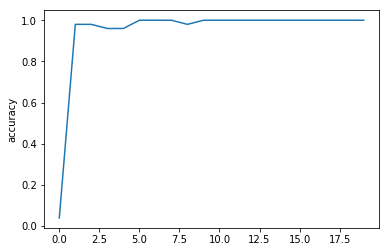

In [26]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_conv, labels=y_))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.global_variables_initializer())

acc_steps = []

for i in range(20000):
    batch = mnist.train.next_batch(50)
    if i%1000 == 0:
        train_accuracy = accuracy.eval(feed_dict={
        x:batch[0], y_: batch[1], keep_prob: 1.0})
        acc_steps.append(train_accuracy)
        print("step %d, training accuracy %g"%(i, train_accuracy))
    train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

print("test accuracy %g"%accuracy.eval(feed_dict={
x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

# visualize accuracy
plt.plot(acc_steps)
plt.ylabel('accuracy')
plt.show()

Výsledná presnosť je cca **99,2%**

### Ukážka klasifikácie prostredníctvom nášho modelu

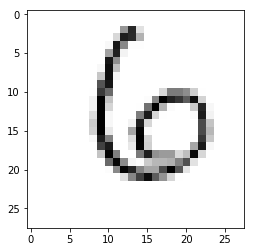

Label: [6]
Predicted Digit: [6]


In [27]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
%matplotlib inline

index = 100

tmp = mnist.test.images[index]
tmp = tmp.reshape((28,28))

plt.imshow(tmp, cmap = cm.Greys, interpolation="nearest")
plt.show()

print("Label: %s"%[a for a,b in enumerate(mnist.test.labels[index]) if b == 1])

prediction=tf.argmax(y_conv,1)
print("Predicted Digit: %s"%prediction.eval(feed_dict={x: [mnist.test.images[index]], keep_prob: 1.0}, session=sess))

### Vizualizácia aktivačných funkcií

In [28]:
import numpy as np
import math

def getActivations(activation,example):
    units = sess.run(activation,feed_dict={x:[example],keep_prob:1.0})
    plotNNFilter(units)

def plotNNFilter(units):
    filters = units.shape[2]
    plt.figure(1, figsize=(20,20))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap=plt.get_cmap('coolwarm'))
    plt.show()
    
example_index = index
example = mnist.test.images[example_index]
example_label = "'MNIST example: Number %s"%[a for a,b in enumerate(mnist.test.labels[example_index]) if b == 1][0]

#code hiding
from IPython.display import HTML
HTML('''<script>
code_show=false; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 

$( document ).ready(code_toggle);
</script>

<a href="javascript:code_toggle()">Zobraziť kód</a>.''')

### CONV 1

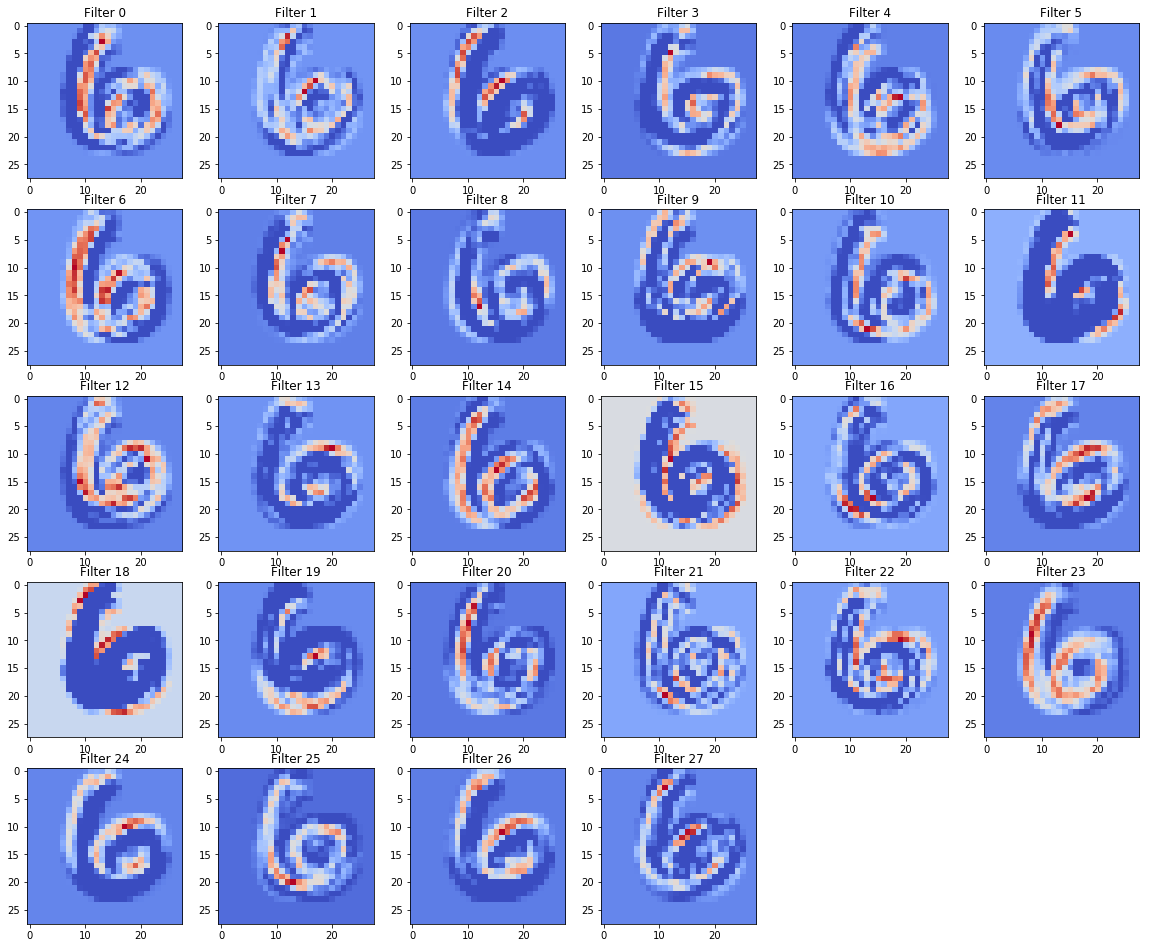

In [29]:
getActivations(h_conv1,example)

### Max Pooling 1

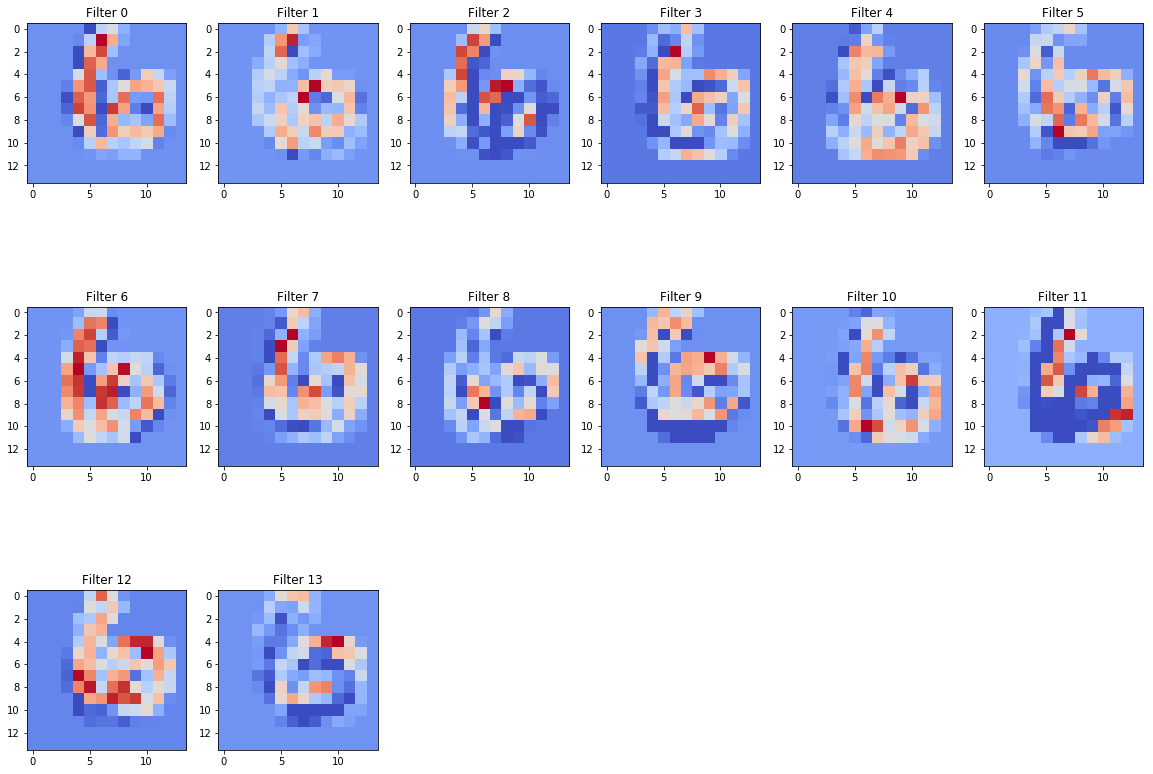

In [30]:
getActivations(h_pool1,example)

### CONV 2

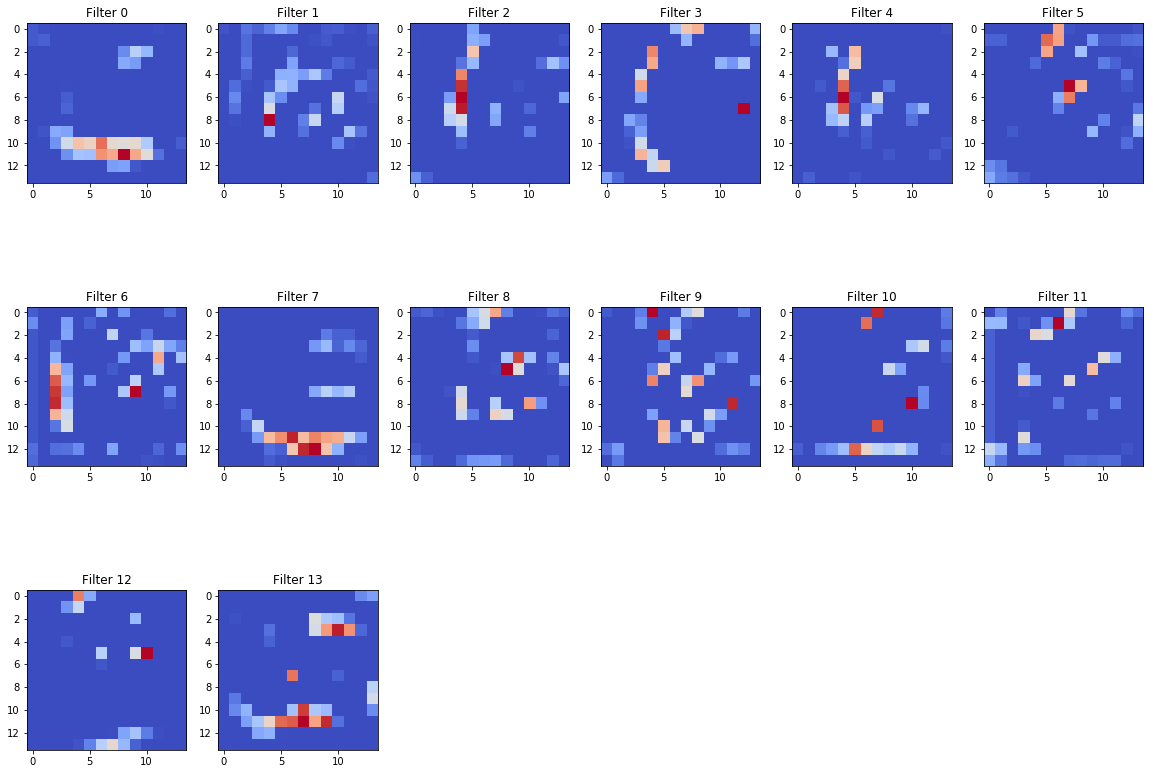

In [31]:
getActivations(h_conv2,example)

### Max Pooling 2

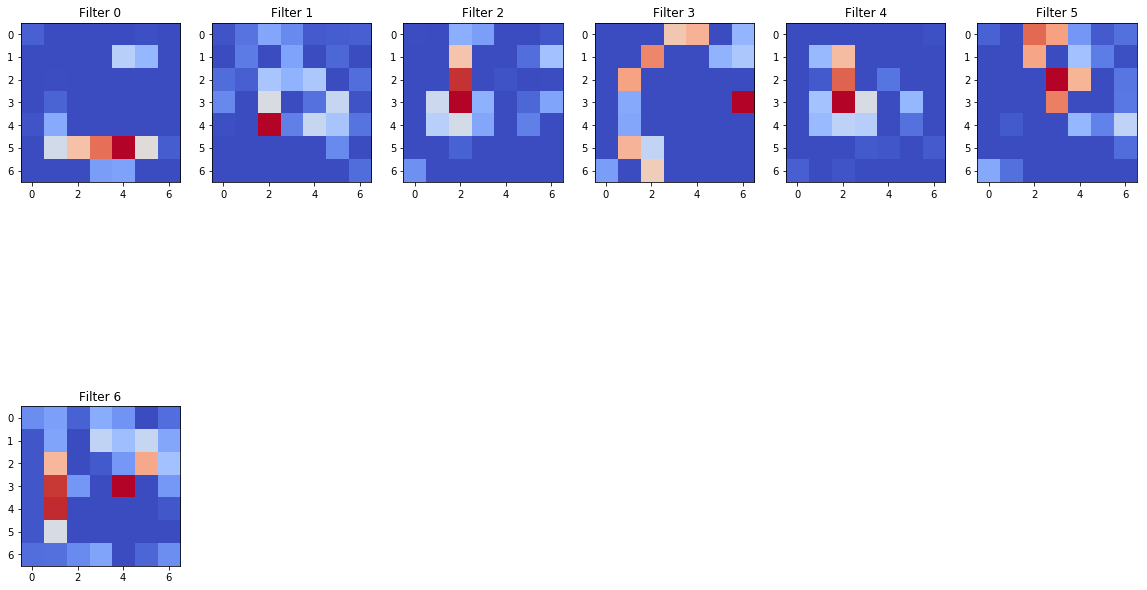

In [32]:
getActivations(h_pool2,example)

### Integrácia modelu do web aplikácie

Uloženie modelu na disk:

In [ ]:
saver = tf.train.Saver()
saver.save(sess, '/home/s8xcm9/models/')

Načítanie modelu z disku:

In [ ]:
saver = tf.train.Saver()
saver.restore(sess, tf.train.latest_checkpoint('/home/s8xcm9/models/'))

#### Kontakty:



<div align="center">
<h1 style="color:blue;">Miroslav Semerád</h1>
<h2>@mldeveloper</h2>
<h2>Miroslav_Semerad@swissre.com</h2>
</div>